In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import gseapy as gp
import matplotlib.pyplot as plt
import swan_vis as swan
import yaml
from snakemake.io import expand

p = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(p)

from proc_revisions.utils import *
from proc_revisions.plotting import *

In [2]:
od = '../../proc_revisions/'
config_file = f'{od}/config.yml'
with open(config_file) as f:
    config = yaml.safe_load(f)

In [3]:
ab = od+expand(config['lr']['talon']['fusion_fix']['ab'], species='human')[0]
unfilt_ab = od+expand(config['lr']['cerberus']['ab'], species='human')[0] 
filt_ab = od+expand(config['lr']['cerberus']['filt_ab'], species='human')[0]
read_annot = od+expand(config['lr']['talon']['full_annot'], species='human')[0]
t_metadata = od+expand(config['ref']['cerberus']['new_gtf_t_info'], species='human')[0]
lib_meta = od+expand(config['lr']['meta'], species='human')[0]
swan_file = od+expand(config['lr']['swan']['sg'], species='human')[0]
cerberus_h5 = od+expand(config['lr']['cerberus']['ca_triplets'], species='human', obs_col='sample')[0]
cerb_t_metadata = od+expand(config['lr']['cerberus']['gtf_t_info'], species='human')[0]
major_isos = od+expand(config['lr']['analysis']['major_isos'], species='human', obs_col='sample')[0]
pi_tpm_table = od+expand(config['lr']['mane']['pi_tpm']['triplet'], species='human', obs_col='sample')[0]

ref_t_metadata = od+expand(config['ref']['new_gtf_t_info'], species='human')[0]
ref_g_metadata = od+expand(config['ref']['new_gtf_g_info'], species='human')[0]

# pp_summary = '../'+expand(config['data']['p_pred']['summary'], species='human')[0]
iq_cerberus_h5 = od+expand(config['lr']['isoquant']['cerberus']['ca_annot'], species='human', obs_col='sample')[0]


iq_gtf = od+expand(config['lr']['isoquant']['gtf'], species='human')[0]
iq_ics = od+expand(config['lr']['isoquant']['cerberus']['ics'], species='human')[0]
iq_ab = od+expand(config['lr']['isoquant']['novel_ab'], species='human')[0]
iq_filt_ab = od+expand(config['lr']['isoquant']['cerberus']['ab'], species='human')[0]

ver = 'v40_cerberus'
min_tpm = 1
gene_subset = 'polya'
obs_col = 'sample'
go_gene_subset = 'protein_coding'
predom_iso_subset = 'protein_coding'

m_lib_meta = od+expand(config['lr']['meta'], species='mouse')[0]

In [60]:
df = pd.read_csv(filt_ab, sep='\t')
df, tids = get_tpm_table(df, 
                         how='iso',
                         min_tpm=min_tpm,
                         gene_subset='polya')

Calculating iso TPM values
Subsetting for polya genes


/Users/fairliereese/Documents/programming/mortazavi_lab/data/paper_rnawg/proc_revisions/utils.py:2087: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]
/Users/fairliereese/Documents/programming/mortazavi_lab/data/paper_rnawg/proc_revisions/utils.py:2086: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()


Enforcing minimum TPM
Total # isos detected: 236615
# isos >= 1 tpm: 213476
Applying gene type and novelty subset
Number of isos reported: 209819


In [61]:
# get max expression of isoform across libraries
df = df.transpose()
df = df.reset_index(drop=True)
df.rename({'index':'dataset'}, axis=1, inplace=True)
df = df.max(axis=0).to_frame()
df.rename({0:'max_tpm'}, axis=1, inplace=True)
df = df.reset_index()
df.rename({'annot_transcript_id':'tid'}, axis=1, inplace=True)

# get transcript lengths
df2 = pd.read_csv(cerb_t_metadata, sep='\t')
df2 = df2[['tid', 't_len']]
df = df.merge(df2, how='left', on='tid')
df['gid'] = df.tid.str.split('[', expand=True)[0]

In [66]:
# get biotype metadata stuff
df3, _, _ = get_gtf_info(how='gene', add_stable_gid=True, ver='v40_cerberus')
df = df.merge(df3, how='left', left_on='gid', right_on='gid_stable')

In [68]:
# log 2 the tpms
df['log_tpm'] = np.log2(df.max_tpm)

# split by biotype (ie the long ones are probably lncrnas)
# bin by length and do boxplot / violinplot
max_t_len = 15000
bins = [i for i in range(0, max_t_len+1000, 1000)]
bins += [df.t_len.max(axis=0)]
df['len_bin'] = pd.cut(df.t_len, bins)

# make nicer bin names
hr_bin_dict = {}
for b in df.len_bin.unique():
    bmin = int(str(b)[1:].split(',')[0])
    if bmin == max_t_len:
        bmin = str(int(bmin/1000))
        hr_bin_dict[b] = f'{bmin}+'
    else:
        bmin = str(int(bmin/1000))
        bmax = str(int(int(str(b).split(', ')[1][0:-1])/1000))
        hr_bin_dict[b] = f'{bmin}-{bmax}'
           
df['hr_len_bin'] = df['len_bin'].map(hr_bin_dict)

In [69]:
df[['biotype_category', 'tid']].groupby('biotype_category').count()

,tid
biotype_category,
lncRNA,12773
protein_coding,191325
pseudogene,5721


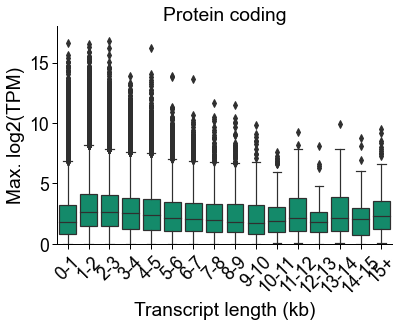

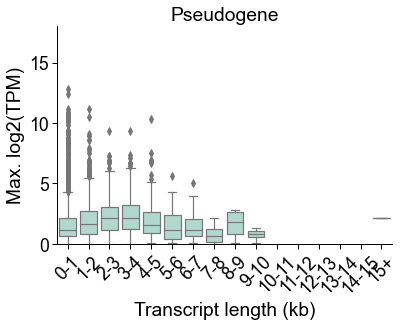

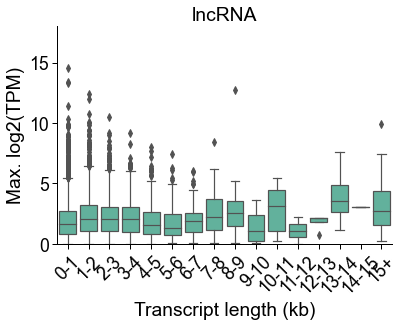

In [84]:
sns.set_context('paper', font_scale=2)
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['pdf.fonttype'] = 42

ic_colors, order = get_ic_nov_colors()
c = ic_colors['Known']
m = {'protein_coding': 'Protein coding',
     'lncRNA': 'lncRNA', 'pseudogene': 'Pseudogene'}
cats = ['Protein coding', 'lncRNA', 'Pseudogene']
c_dict, order = get_shade_colors(c, cats)
df['gene_subset_2'] = df.biotype_category.map(m)
df['gene_subset_2'] = df['gene_subset_2'].astype('category')
df['gene_subset_2'] = df['gene_subset_2'].cat.reorder_categories(cats, ordered=True)
for c in df.gene_subset_2.unique().tolist():
    temp = df.loc[df.gene_subset_2==c].copy(deep=True)
    ax = sns.boxplot(temp, x='hr_len_bin', y='log_tpm', color=c_dict[c])
    ax.tick_params(axis='x', rotation=45)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set(title=c, xlabel='Transcript length (kb)', ylabel='Max. log2(TPM)',
           ylim=(0,18))
    plt.show()

In [115]:
# how long are predomiant isoforms? how often are they ISM isoforms? how much shorter are they than the known isoforms of a gene?
df = pd.read_csv(pi_tpm_table, sep='\t')

# # get only predominant
# df = df.loc[df.triplet_rank==1]
# df.head()

In [116]:
# get transcript lengths
df2 = pd.read_csv(cerb_t_metadata, sep='\t')
df2 = df2[['tid', 't_len']]
df = df.merge(df2, how='left', on='tid')

In [117]:
# get biotype metadata stuff
df3, _, _ = get_gtf_info(how='gene', add_stable_gid=True, ver='v40_cerberus')
df = df.merge(df3, how='left', left_on='gid', right_on='gid_stable')

In [118]:
# limit to polya genes
cats = get_polya_cats()
df = df.loc[df.biotype_category.isin(cats)]
df.head()

,tid,sample,triplet_tpm,triplet_pi,gid_x,gname_x,triplet_rank,t_len,gid_y,gname_y,length,biotype,biotype_category,tf,MANE_Select,MANE_Plus_Clinical,gid_stable
1891,"ENSG00000285988[1,2,2]",pc9,2.074560,45.454548,ENSG00000285988,ENSG00000285988,1,3096,ENSG00000285988.1,ENSG00000285988,103395.0,lncRNA,lncRNA,False,False,False,ENSG00000285988
1892,"ENSG00000285988[1,1,2]",pc9,1.675734,36.363636,ENSG00000285988,ENSG00000285988,2,2912,ENSG00000285988.1,ENSG00000285988,103395.0,lncRNA,lncRNA,False,False,False,ENSG00000285988
1893,"ENSG00000285988[1,1,1]",pc9,0.845911,18.181818,ENSG00000285988,ENSG00000285988,3,718,ENSG00000285988.1,ENSG00000285988,103395.0,lncRNA,lncRNA,False,False,False,ENSG00000285988
1894,"ENSG00000285988[1,2,2]",mcf10a,1.064827,100.000000,ENSG00000285988,ENSG00000285988,1,3096,ENSG00000285988.1,ENSG00000285988,103395.0,lncRNA,lncRNA,False,False,False,ENSG00000285988
1895,"ENSG00000285988[1,2,2]",calu3,3.561985,72.727270,ENSG00000285988,ENSG00000285988,1,3096,ENSG00000285988.1,ENSG00000285988,103395.0,lncRNA,lncRNA,False,False,False,ENSG00000285988


In [119]:
print(len(df.index))
df = df[['tid', 't_len', 'triplet_rank']].drop_duplicates()
print(len(df.index))

3558738
1139286


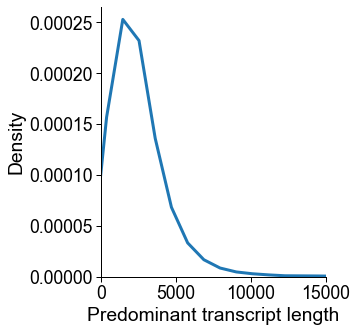

In [121]:
# distribution of lengths of predominant transcripts (most highly-expressed)
temp = df.loc[df.triplet_rank==1][['tid', 't_len']].drop_duplicates()
ax = sns.displot(temp, x='t_len', kind='kde', linewidth=3)
ax.set(xlim=(0, 15000), xlabel='Predominant transcript length')

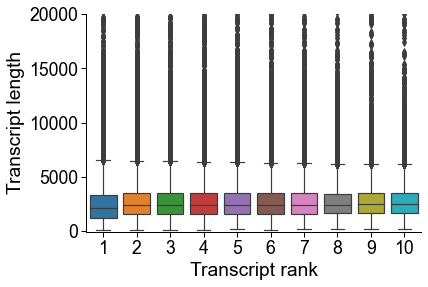

In [131]:
# distribution of lengths of transcripts at different ranks
max_rank = 10
temp = df.loc[df.triplet_rank <= max_rank].copy(deep=True)
ax = sns.boxplot(temp, x='triplet_rank', y='t_len')
ax.set(ylim=(-20,20000), ylabel='Transcript length',
       xlabel='Transcript rank', alpha=1)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

In [149]:
# what's the median length for each thing?
for i in temp.triplet_rank.unique().tolist():
    med = temp.loc[temp.triplet_rank==i, 't_len'].median(axis=0)
    print(f'Median transcript length for rank {i}: {med}')

Median transcript length for rank 1: 2176.0
Median transcript length for rank 2: 2409.0
Median transcript length for rank 3: 2431.0
Median transcript length for rank 4: 2445.0
Median transcript length for rank 5: 2442.0
Median transcript length for rank 6: 2447.0
Median transcript length for rank 7: 2448.0
Median transcript length for rank 8: 2459.0
Median transcript length for rank 9: 2468.0
Median transcript length for rank 10: 2480.0


In [147]:
# # # perform a wilcoxon rank sum test between most highly expressed (rank 1, predominant)
# # # and the rest
# # from statsmodels.stats.multitest import multipletests

# st_df = pd.DataFrame()
# for i in temp.triplet_rank.unique().tolist():
#     if i == 1:
#         continue
#     x = temp.loc[temp.triplet_rank==1, 't_len'].tolist()
#     y = temp.loc[temp.triplet_rank==i, 't_len'].tolist()
#     statistic, pval = st.ranksums(x, y)
#     # print(f'Rank 1 vs. rank {i}')
#     # print(f'Wilcoxon rank-sum stat: {statistic}, pval: {pval}')
#     # print()
#     data = [len(x), len(y), statistic, pval, i]
#     cols = ['n_x', 'n_y', 'statistic', 'pval', 'triplet_rank']
#     temp2 = pd.DataFrame(data=[data], columns=cols)
#     st_df = pd.concat([st_df, temp2], axis=0) 

# # # FDR correction
# # _, adj_p_vals, _, _ = multipletests(st_df.pval.tolist(), method='fdr_bh')
# # st_df['adj_pval'] = adj_p_vals
# # st_df

In [148]:
# st_df.head()